<a class="anchor" id="import_libraries"></a>
## Import Libraries

In [5]:
# Data and Numbers
import pandas as pd
import numpy as np
import datetime as dt


from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import precision_score, recall_score,\
precision_recall_curve,f1_score, fbeta_score,\
accuracy_score, confusion_matrix, roc_auc_score, roc_curve

from sklearn.preprocessing import StandardScaler
from sklearn.externals.six import StringIO


# Saving
import joblib
import pickle

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

from sklearn.tree import export_graphviz
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Oswald']
font = {'size'   : 12}
plt.rc('font', **font)

%precision 5

'%.5f'

<a class="anchor" id="load_the_data"></a>
## Load the Data

In [7]:
# Bring in pickled data file with cleaned data
with open('data/clean_df.pickle', 'rb') as read_file:
     df = pickle.load(read_file)
with open('data/df.pickle','rb') as read_file:
     df = pickle.load(read_file)

In [ ]:
df.columns

<a class="anchor" id="modeling"></a>
## Modeling

<a class="anchor" id="set-up"></a>
### Set up features and target=status_bool

In [5]:
# Category Dummies
cat_dummies = pd.get_dummies(df['cat_list'], drop_first=True)
# Country Dummies
country_dummies = pd.get_dummies(df['country'], drop_first=True)
# State Dummies
state_dummies = pd.get_dummies(df['state'], drop_first=True)

In [6]:
df['state'].unique()

array(['0_other_state', 'CA', '2', 'NY', 'MA', 'FL', 'H9', 'WA', 'IL',
       'TX', 'unknown', '7', 'PA'], dtype=object)

In [7]:
# Create dummy variables for category, country, and state

X_col_nodummies = [
    'funding_rounds', 'float_avg_time_bw_rounds', 'avg_raise_usd',
    'float_time_bw_first_rounds'
]
X_nodummies = df[X_col_nodummies]

In [8]:
# Merge in dummies to feature matrix
X = X_nodummies.merge(cat_dummies, left_index=True, right_index=True).merge(
    country_dummies, left_index=True, right_index=True).merge(state_dummies,
                                                              left_index=True,
                                                              right_index=True)

# Add intercept column
X['intercept'] = 1

In [9]:
# Target
y = df.status_bool

In [10]:
# Export for visualizations in Tableau
df.to_csv('data/df.csv')

<a class="anchor" id="pairplot"></a>
### Look at data on pairplot, inspect for feature interactions

<a class="anchor" id="tar-dist"></a>
### Inspect distribution of targets

In [26]:
# Count target values
target_count = y.value_counts()

# # print class balance
print(f'Class 0: {target_count[0]}')
print(f'Class 1: {target_count[1]}')
print(f'Proportion: {round(target_count[0] / target_count[1], 2)} : 1')
print('Percentage of Majority Class: {:f}'.format(
    round(target_count[0] / sum(target_count), 4) * 100))

Class 0: 3667
Class 1: 1931
Proportion: 1.9 : 1
Percentage of Majority Class: 65.510000


The dataset is not very imbalanced, so we should not need to oversample the minority class, but later on we will try oversampling to see how it affects the results

In [27]:
target_count

0.0    3667
1.0    1931
Name: status_bool, dtype: int64

<a class="anchor" id="split"></a>
### Train test split + standardize the data

In [76]:
# Split the data with 80% to train and 20% to test
# Stratify to ensure train and test sets have 
# similar proportions of either target class
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=40,
                                                    stratify=y)

In [77]:
# Standardize the data

scaler = StandardScaler()

# Fit the scaler using the training data and scale it
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train.values),
                              columns=X.columns)

# Scale the test data
X_test_scaled = pd.DataFrame(scaler.transform(X_test.values),
                             columns=X.columns)

<a class="anchor" id="logreg1"></a>
Going to test out a bunch of classification algorithms to see which performs the best then try to optimize the top ones by tuning their hyperparameters as well as feature selection and any additional feature engineering
### Logistic Regression

In [31]:
# Instantiate model
logreg = LogisticRegression(C=10, solver='lbfgs')

# Fit model to the training data
logreg.fit(X_train_scaled, y_train)

# Pickle this for later
joblib.dump(logreg, 'logreg.pkl')

In [32]:
# Calculate ROC curve for logistic regression
fpr_lr, tpr_lr, thresholds_lr = roc_curve(
    y_test,
    logreg.predict_proba(X_test_scaled)[:, 1])

# Calculate area under the curve (AUC) for ROC
auc_lr = roc_auc_score(y_test, logreg.predict_proba(X_test_scaled)[:, 1])

<a class="anchor" id="eval"></a>
### Evaluating the Models

#### Calculating f_beta
The F-beta score weights recall more than precision by a factor of beta

Weigh recall more heavily than precision because in the case of venture capital investments, it is worse to miss out on a potential unicorn investment (10-100X return) (type II error - false negative) than to invest in a dud (1X loss) (type 1 error - false positive), however we won't place all weight on recall as it is still valuable for a VC firm to distinguish itself by reducing the amount of "duds" it invests in

If viewing from the prospective of a founder, they would prioritize precision since starting a company requires a lot of time and effort, they want to really improve the likelihood of starting a successful company

Find the probability threshold which optimizes the f_beta score

In [98]:
def fbeta(model, y_test=y_test, X_test=X_test_scaled):
    """
    Calculate the probability threshold that yields the highest f_beta value
    input: fitted model, y_test, X_test
    """
    prob_thresholds = np.arange(0, 1, 0.005)
    fbeta = []
    for prob in prob_thresholds:
        fbeta.append(
            fbeta_score(y_test,
                        model.predict_proba(X_test)[:, 1] > prob, 3))
    all_fbeta = list(zip(prob_thresholds, fbeta))
    best_fbeta = max(list(zip(prob_thresholds, fbeta)), key=lambda x: x[1])
    print(
        'Probability that yields the best fbeta score is {} with fbeta={:5f}'.
        format(best_fbeta[0], best_fbeta[1]))
    return all_fbeta, best_fbeta

In [48]:
# Calculate fbeta for logistic regression
all_fbeta_lr, best_fbeta_lr = fbeta(logreg, X_test=X_test_scaled)
p_thresh = best_fbeta_lr[0]

Probability that yields the best fbeta score is 0.115 with fbeta=0.846360


/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/metric

#### Precision Recall Curve (with f_beta)

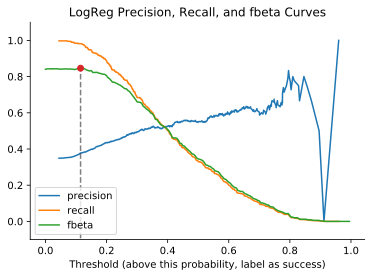

In [49]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(
    y_test,
    logreg.predict_proba(X_test_scaled)[:, 1])

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:], label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.plot(list(zip(*all_fbeta_lr))[0],
         list(zip(*all_fbeta_lr))[1],
         label='fbeta')
plt.plot([best_fbeta_lr[0], best_fbeta_lr[0]], [-1, best_fbeta_lr[1]],
         '--',
         color='black',
         alpha=0.5)
plt.plot(best_fbeta_lr[0], best_fbeta_lr[1], 'o')
plt.ylim([-0.1, 1.1])
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as success)')
plt.title('LogReg Precision, Recall, and fbeta Curves')
sns.despine()
plt.savefig('img/init_lr_precisionrecallcurve.png')
plt.savefig('img/init_lr_precisionrecallcurve.svg')

In [50]:
lr_coefs = list(zip(X.columns, logreg.coef_[0]))
lr_coefs_df = pd.DataFrame(lr_coefs)
lr_top_coefs = [x for x in lr_coefs if np.abs(x[1]) > .07]
lr_top_coefs = sorted(lr_top_coefs, key=(lambda x: x[1]), reverse=True)
lr_top_coefs_df = pd.DataFrame(lr_top_coefs)
lr_top_coefs_df.to_csv('data/lr_coefs.csv')

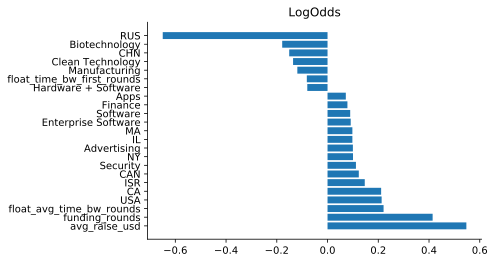

In [51]:
plt.barh([x[0] for x in lr_top_coefs], width=[x[1] for x in lr_top_coefs])
plt.title('LogOdds')
plt.grid(b=False)
sns.despine()

<a class="anchor" id="modelcomp"></a>
## Model Comparison

In [9]:
models = ['lr']
model_aucs = [
    auc_lr, 
]
model_fbetas = [
    best_fbeta_lr[1]
]
model_names = [
   'Logistic Regression'
]

In [266]:
# Print AUC Scores
for model in list(zip(model_names, model_aucs)):
    print("ROC AUC score = {:3f} for {}".format(model[1], model[0]))

ROC AUC score = 0.712248 for Logistic Regression
ROC AUC score = 0.689236 for Decision Tree
ROC AUC score = 0.615624 for KNN
ROC AUC score = 0.684194 for Bernoulli Naive Bayes
ROC AUC score = 0.623865 for Gaussian Naive Bayes
ROC AUC score = 0.722403 for Support Vector Machine
ROC AUC score = 0.731721 for XGBoost
ROC AUC score = 0.677459 for Bagged Decision Tree
ROC AUC score = 0.705306 for Random Forest


In [267]:
# Print fbeta Scores
for model in list(zip(model_names, model_fbetas)):
    print("f_beta score = {:3f} for {}".format(model[1], model[0]))

f_beta score = 0.846360 for Logistic Regression
f_beta score = 0.838622 for Decision Tree
f_beta score = 0.743726 for KNN
f_beta score = 0.844085 for Bernoulli Naive Bayes
f_beta score = 0.842611 for Gaussian Naive Bayes
f_beta score = 0.846819 for Support Vector Machine
f_beta score = 0.846085 for XGBoost
f_beta score = 0.847038 for Bagged Decision Tree
f_beta score = 0.843107 for Random Forest


In [100]:
# Create an attribute for the feature names
lr_tuned.feature_names = X_sel.columns
lr_tuned.target_names = ['Fail', 'Success']

In [101]:
X_sel.columns

Index(['funding_rounds', 'float_time_bw_first_rounds',
       'float_avg_time_bw_rounds', 'avg_raise_usd', 'Advertising', 'Apps',
       'Biotechnology', 'Clean Technology', 'Education', 'Enterprise Software',
       'Finance', 'Hardware + Software', 'Manufacturing', 'Mobile', 'Software',
       'CAN', 'CHN', 'ISR', 'RUS', 'USA', 'CA', 'IL', 'MA', 'NY', 'intercept'],
      dtype='object')

In [102]:
lr_tuned.feature_display_names = [
    'Number of Funding Rounds', 'Time Between First Rounds (months)',
    'Average Time Between Rounds (months)', 'Average Raise Amount ($)',
    'Advertising', 'Apps', 'Biotechnology', 'Clean Technology', 'Education',
    'Enterprise Software', 'Finance', 'Hardware + Software', 'Manufacturing',
    'Mobile', 'Software', 'Canada', 'China', 'Israel', 'Russia',
    'United States', 'California', 'Illinois', 'Massachusetts', 'New York',
    'int'
]

In [103]:
# Pickle this for later
with open("lr_tuned.pkl", "wb") as f:
    pickle.dump(lr_tuned, f)

#### Interpreting Coefficients and Intercept

In [104]:
# Intercept
lr_tuned.intercept_[0]

-0.7676364014515489

In [105]:
# convert intercept log-odds to probability
logodds = lr_tuned.intercept_
odds = np.exp(logodds)
prob = odds / (1 + odds)
prob[0]
print(
    'All else considered, companies that make it past their\
    first funding round, probability of success is {:.2f}%'
    .format(100 * prob[0]))

All else considered, companies that make it past their first funding round, probability of success is 31.70%


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


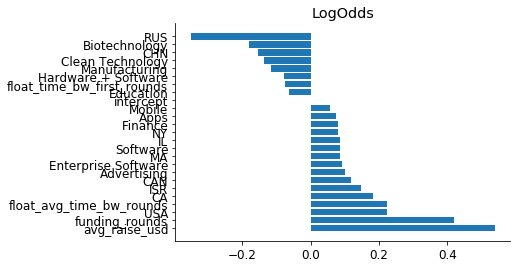

In [106]:
lr_tuned_coefs = pd.DataFrame(sorted(list(zip(X_sel.columns,
                                              lr_tuned.coef_[0])),
                                     key=(lambda x: x[1]),
                                     reverse=True),
                              columns=['Feature', 'Coefficient'])
lr_tuned_coefs['Odds'] = np.exp(lr_tuned_coefs.Coefficient)

# Plot coefficients
plt.barh(lr_tuned_coefs['Feature'], width=lr_tuned_coefs['Coefficient'])
plt.title('LogOdds')
plt.grid(b=False)
sns.despine()

# Save coefficients for plotting in Tableau
with open("lr_tuned_coefs.pkl", "wb") as f:
    pickle.dump(lr_tuned_coefs, f)

In [111]:
df['float_time_bw_first_rounds'].std()

306.2895971840483

In [107]:
lr_tuned_coefs

,Feature,Coefficient,Odds
0,avg_raise_usd,0.539126,1.714508
1,funding_rounds,0.418949,1.520363
2,USA,0.222762,1.249523
3,float_avg_time_bw_rounds,0.222558,1.249268
4,CA,0.182392,1.200085
5,ISR,0.146461,1.157729
6,CAN,0.118981,1.126348
7,Advertising,0.101296,1.106604
8,Enterprise Software,0.092859,1.097307
9,MA,0.086448,1.090295


<a class="anchor" id="viz"></a>
## Visualizing Results

To contextualize the results, look at the confusion matrix and assign relative dollar amounts to false positives and negatives and true positives and negatives

Since model performances were comparable, we'll move ahead with the logistic regression model as it is the easiest to interpret

In [127]:
lr_tuned.predict(X_sel_test_scaled)

array([0., 0., 0., ..., 0., 0., 0.])

In [128]:
annots = pd.DataFrame([['TN', 'FP'], ['FN', 'TP']])
type(annots)
annots

,0,1
0,TN,FP
1,FN,TP


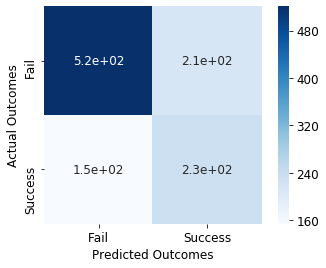

<Figure size 432x288 with 0 Axes>

In [137]:
lr_confusion = confusion_matrix(y_sel_test, [
    1 if item[1] > 0.35 else 0
    for item in lr_tuned.predict_proba(X_sel_test_scaled)
])

sns.heatmap(lr_confusion,
            cmap=plt.cm.Blues,
            annot=True,
            square=True,
            xticklabels=['Fail', 'Success'],
            yticklabels=['Fail', 'Success'])  
b, t = plt.ylim()  # discover the values for bottom and top
b += 0.5  # Add 0.5 to the bottom
t -= 0.5  # Subtract 0.5 from the top
plt.ylim(b, t)  # update the ylim(bottom, top) values
plt.xlabel('Predicted Outcomes')
plt.ylabel('Actual Outcomes')
plt.show()
plt.savefig('img/confusion.png')